In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [38]:
df = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', index_col="Date", parse_dates=["Date"])
df

,Close,Open,High,Low,Volume,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32970.0,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47710.0,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112430.0,-1.00%,93229.35


In [39]:
# df = pd.read_csv('bitcoin_preprocessed.csv')
# df = df.drop(columns=['Unnamed: 0'])
# for name in df.columns[1:-2]:
#     df[name] = df[name].str.replace(',', '').astype(float)
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# df = df.sort_values('Date')
# #df['Average'] = (df['High'] + df['Low']) / 2.0
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index('Date')
# df

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5282 entries, 2010-07-18 to 2025-01-01
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     5282 non-null   float64
 1   Open      5282 non-null   float64
 2   High      5282 non-null   float64
 3   Low       5282 non-null   float64
 4   Volume    5282 non-null   float64
 5   Change %  5282 non-null   object 
 6   Average   5282 non-null   float64
dtypes: float64(6), object(1)
memory usage: 330.1+ KB


### Data visualization

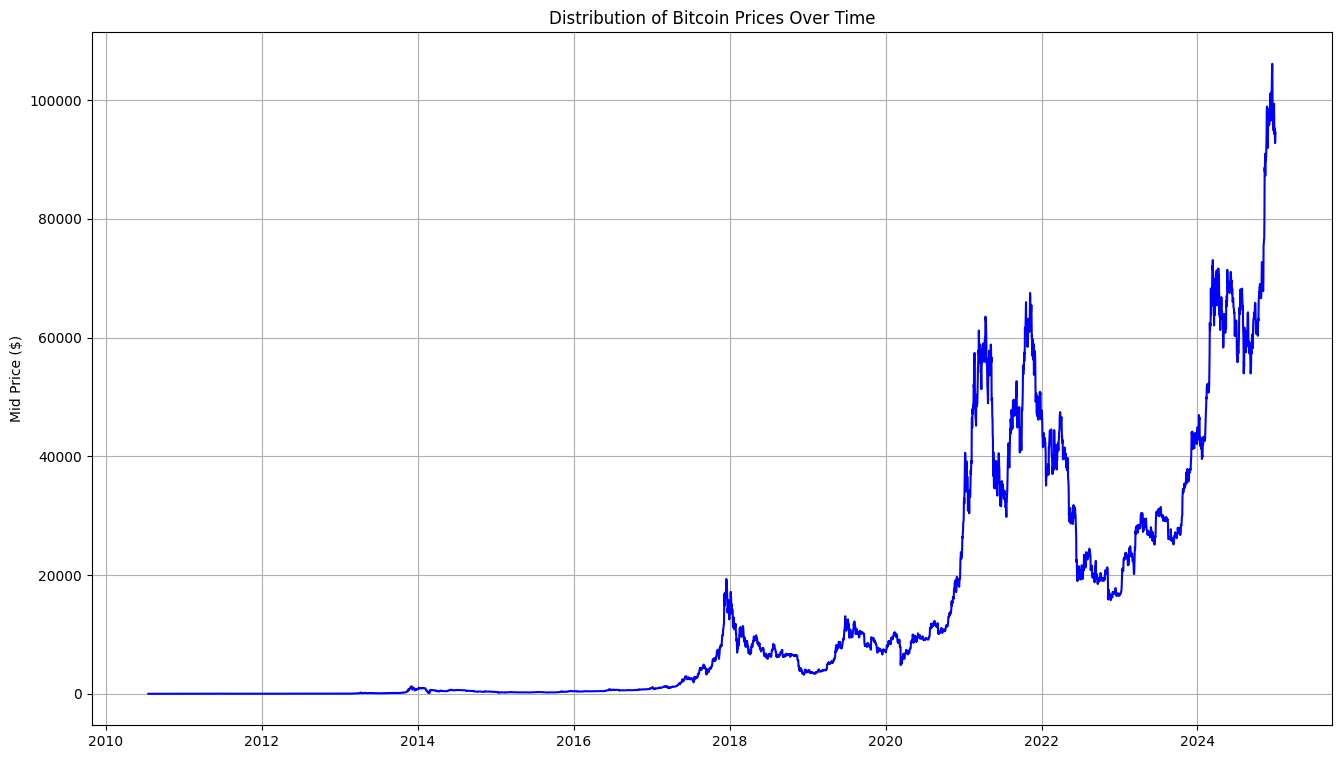

In [41]:
plt.figure(figsize=(16, 9))
plt.plot(df.index, df['Close'], linestyle='-', color='b')
plt.title('Distribution of Bitcoin Prices Over Time')
plt.ylabel('Mid Price ($)')
plt.grid(True)
plt.show()

Trzy okna w normalizacji:
- od początku do 2017-01-01
- od 2017-01-02 do 2020-12-15
- od 2020-12-16 do 2022-02-10


### Splitting Data Into a Training Set and a Test Set

In [42]:
# Set your test size as a percentage (e.g., 20% for testing)
test_size_percentage = 20

test_size = int(np.floor(len(df) * (test_size_percentage / 100)))
train_df = df[:-test_size]
test_df = df[-test_size:]

print(f"Training set size: {len(train_df)} records")
print(f"Test set size: {len(test_df)} records\n")
print(f"The dataset has {df.shape[0]} rows")

Training set size: 4226 records
Test set size: 1056 records

The dataset has 5282 rows


In [43]:
train_df.tail()

,Close,Open,High,Low,Volume,Change %,Average
Date,,,,,,,
2022-02-06,42392.2,41411.9,42614.8,41176.3,31200.0,2.37%,41895.55
2022-02-07,43833.9,42385.2,44468.3,41695.4,76600.0,3.40%,43081.85
2022-02-08,44038.2,43833.9,45399.8,42705.0,92880.0,0.47%,44052.40
2022-02-09,44388.9,44038.2,44800.4,43163.0,50920.0,0.80%,43981.70
2022-02-10,43521.0,44388.9,45755.2,43242.5,89690.0,-1.96%,44498.85


In [44]:
test_df.head()

,Close,Open,High,Low,Volume,Change %,Average
Date,,,,,,,
2022-02-11,42388.4,43519.3,43915.1,42023.4,69950.0,-2.60%,42969.25
2022-02-12,42205.2,42388.4,43006.4,41776.8,37880.0,-0.43%,42391.60
2022-02-13,42061.1,42205.5,42725.1,41880.1,25880.0,-0.34%,42302.60
2022-02-14,42550.3,42061.1,42799.7,41591.3,53600.0,1.16%,42195.50
2022-02-15,44544.4,42550.3,44722.6,42460.1,56340.0,4.69%,43591.35


In [45]:
# Take the Average column and transform to arrays
train_data = train_df['Close'].values.reshape(-1, 1)
test_data = test_df['Close'].values.reshape(-1, 1)

In [46]:
# df[(df.index.year == 2020) & (df.index.month == 12)]

### Normalizing the Data

In [47]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

Due to your earlier observation that different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here, you choose a window size of 2500.

**Tip**: When choosing the window size, make sure it's not too small. When you perform windowed normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue.

In [48]:
# df.loc[:"2017-01-02", :]

In [49]:
# train_data[:2359,:]

In [50]:
# until 2017-01-01
scaler.fit(train_data[:2359, :])
train_data[:2359, :] = scaler.transform(train_data[:2359, :])

# 2017-01-01 to 2020-12-15
scaler.fit(train_data[2359:3802, :])
train_data[2359:3802, :] = scaler.transform(train_data[2359:3802, :])

# 2020-12-16 to 2022-02-10
scaler.fit(train_data[3802:, :])
train_data[3802:, :] = scaler.transform(train_data[3802:, :])

In [51]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
train_data_reshaped = train_data.reshape(-1, 1)

# Normalize test data or no...
test_data = scaler.transform(test_data).reshape(-1)
test_data_original = scaler.inverse_transform(test_data.reshape(-1, 1))

You can now smooth the data using the exponential moving average. This helps eliminate the inherent raggedness of bitcoin prices and produce a smoother curve.

In [52]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma * train_data[ti] + (1 - gamma) * EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

### Simple Moving Average

In [53]:
# Standard average method
window_size = 50  # days
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    date = df.index[pred_idx]

    # mean of previous window_size days
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size: pred_idx]))

    # Calculate MSE for the prediction
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx])**2)
    std_avg_x.append(date)

mse_error = 0.5 * np.mean(mse_errors)
print(f'MSE error for standard averaging: {mse_error:.5f}')


MSE error for standard averaging: 0.00396


In [54]:
range(window_size, N)

range(50, 4226)

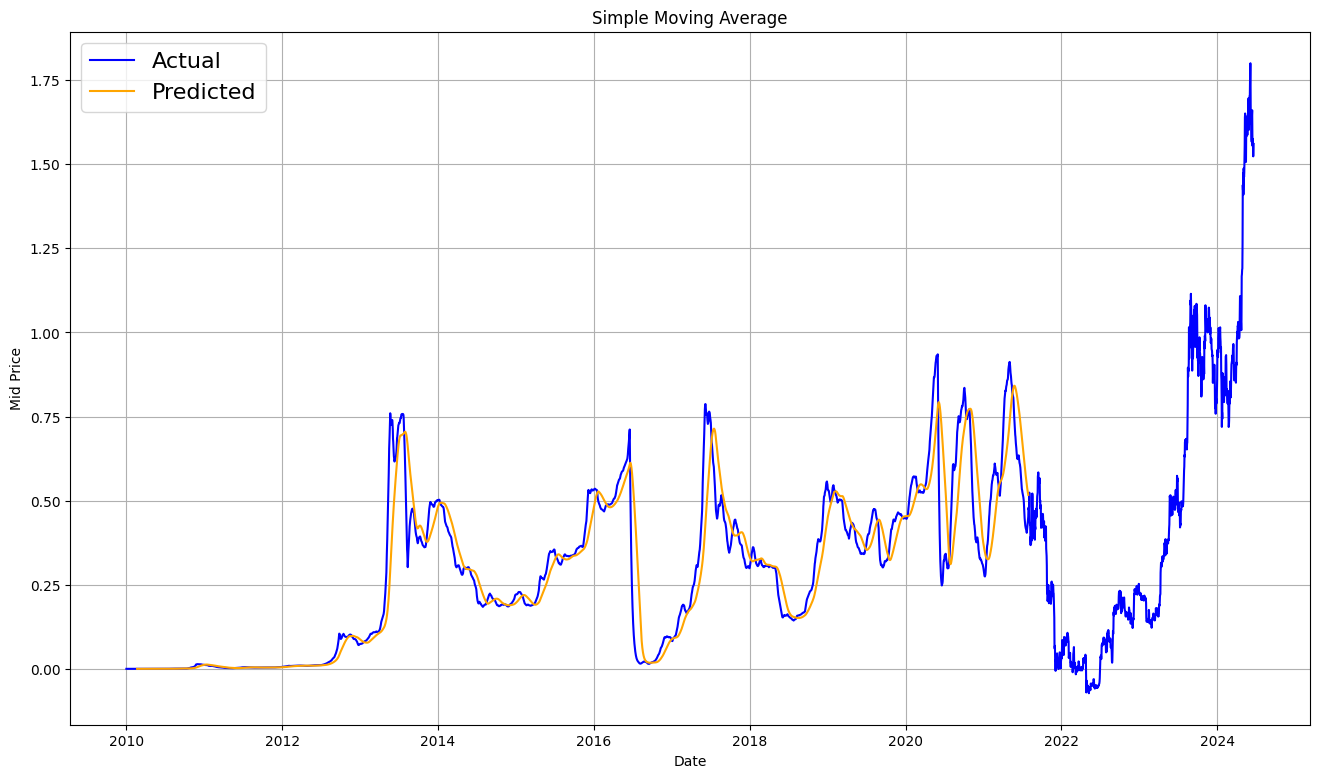

In [55]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=16)
plt.grid(True)
plt.show()

### Exponential Moving Average

The formula for the **Exponential Moving Average (EMA)** is as follows:

$$
\text{EMA}_t = \alpha \times X_t + (1 - \alpha) \times \text{EMA}_{t-1}
$$

Where:
- $ \text{EMA}_t $ is the EMA value at time $ t $.
- $ X_t $ is the actual data value at time $ t $ (e.g., the price or value at time $ t $).
- $ \text{EMA}_{t-1} $ is the EMA value at time $ t-1 $, the previous time step.
- $ \alpha $ is the smoothing factor, calculated as:
  $$
  \alpha = \frac{2}{m + 1}
  $$
  Where $ m $ is the number of periods over which the EMA is calculated. For example, if you are calculating a 10-day EMA, $ m $ would be 10.

### Intuition:
- The **smoothing factor** $ \alpha $ determines the weight given to the most recent data point compared to the previous EMA value. The larger the value of $ \alpha $, the more weight is given to recent values. For example, a $\alpha=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average.
- The EMA is more responsive to recent changes in the data compared to a simple moving average (SMA), which gives equal weight to all data points in the window.

### Calculation Steps:
1. Start by calculating the simple moving average (SMA) for the initial period (usually the first $ N $ data points).
2. Then, use the EMA formula to update the value for subsequent periods, incorporating both the previous EMA and the new data point.



In [56]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

alpha = 0.5

for pred_idx in range(1, N):
    running_mean = running_mean * alpha + (1.0 - alpha) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    run_avg_x.append(date)

ema_mse_error = 0.5 * np.mean(mse_errors)
print(f"MSE error for EMA Moving Average: {ema_mse_error:.5f}")

MSE error for EMA Moving Average: 0.00007


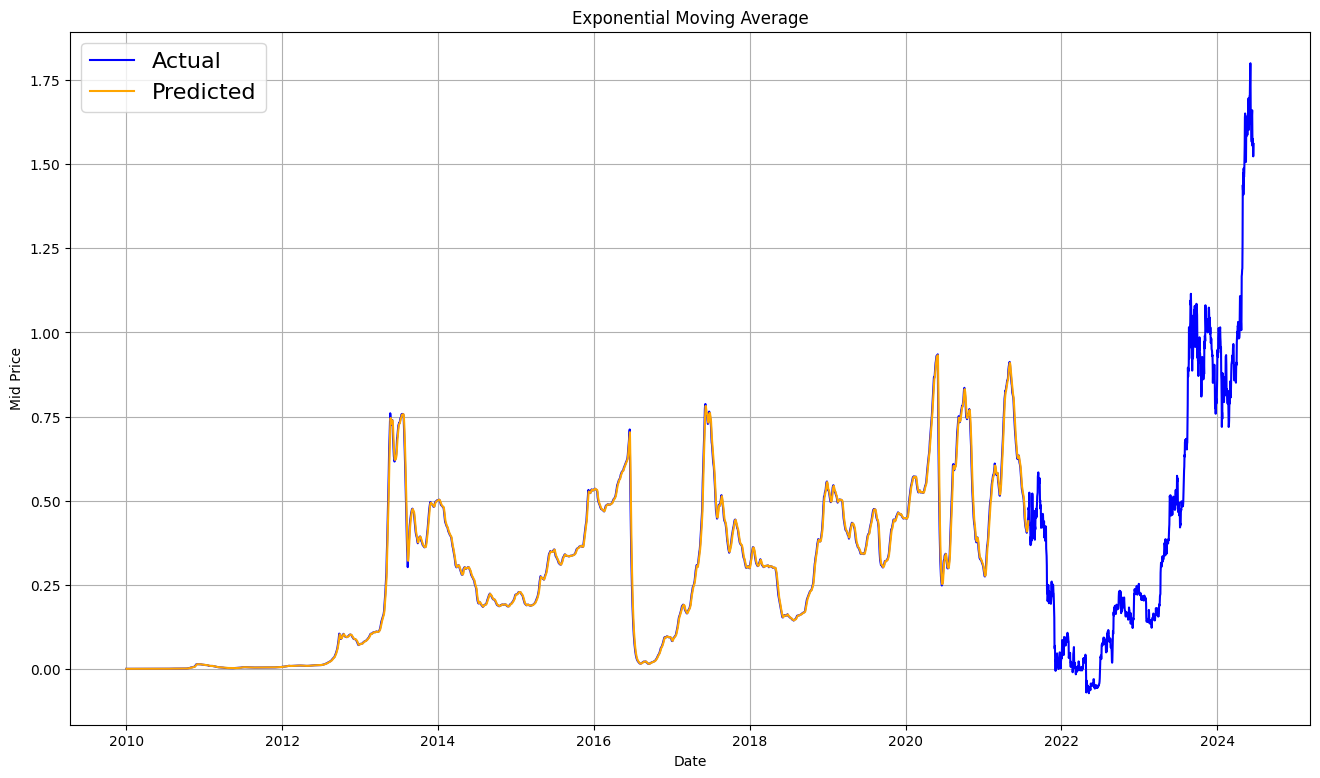

In [57]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [58]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

alpha = 0.7

for pred_idx in range(1, N):
    running_mean = running_mean * alpha + (1.0 - alpha) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    run_avg_x.append(date)

ema_mse_error = 0.5 * np.mean(mse_errors)
print(f"MSE error for EMA Moving Average: {ema_mse_error:.5f}")

MSE error for EMA Moving Average: 0.00017


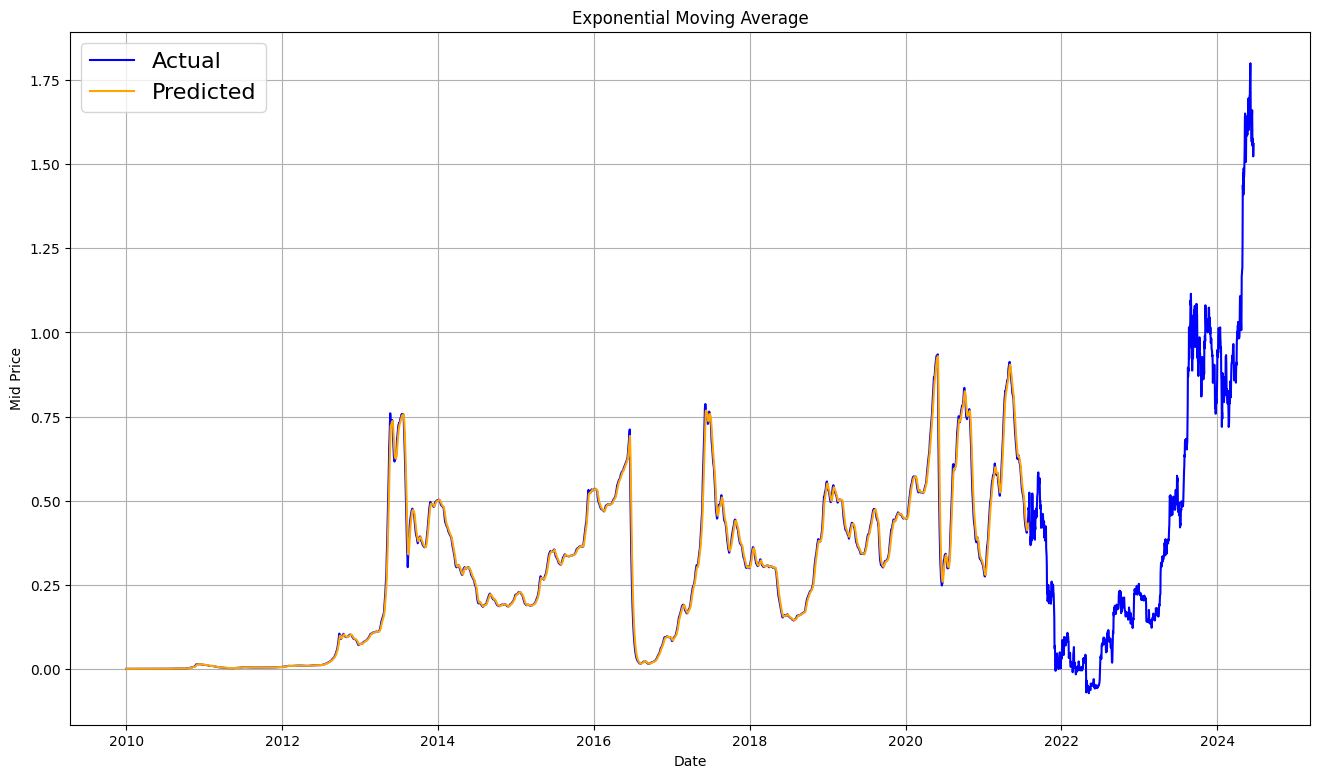

In [59]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [60]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []
mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

alpha = 0.1

for pred_idx in range(1, N):
    running_mean = running_mean * alpha + (1.0 - alpha) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    run_avg_x.append(date)

ema_mse_error = 0.5 * np.mean(mse_errors)
print(f"MSE error for EMA Moving Average: {ema_mse_error:.5f}")

MSE error for EMA Moving Average: 0.00002


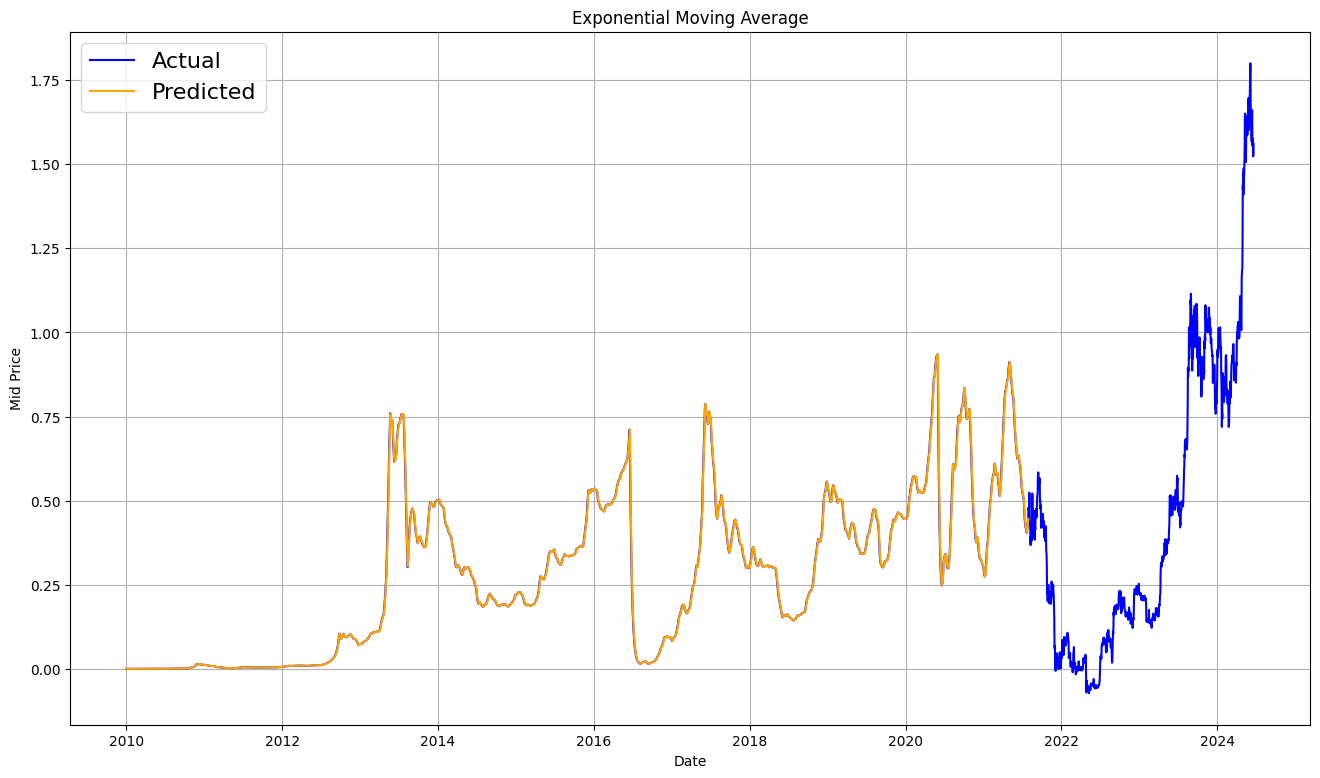

In [61]:
xticks_position = range(0, df.shape[0], 365*2)
xticks_labels = df.index[xticks_position].strftime('%Y')

plt.figure(figsize = (16, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Actual')
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Predicted')
plt.xticks(xticks_position, xticks_labels)
plt.title('Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

#### If the exponential moving average is this good, why do you need better models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally, what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days? Try to do this, and you will expose the incapability of the EMA method.

Predict more than one step into the future

To make things concrete, let's assume values, say $x_t=0.4$, $EMA=0.5$ and $\alpha = 0.5$

Say you get the output with the following equation
  - Xt+1 = EMAt = γEMAt-1 + (1 - γ)Xt
  - So you have xt+1 = 0.5 * 0.5 + (1-0.5) * 0.4 = 0.45
  - So Xt+1 = EMAt = 0.45

So the next prediction Xt+2 becomes:
  - Xt+2 = γ * EMAt + (1-γ)Xt+1
  - Which is Xt+2 = γ * EMA_t + (1-γ) EMAt = EMAt
  - Or in this example, Xt+2 = Xt+1 = 0.45

So, no matter how many steps you predict in the future, you'll keep getting the same answer for all the future prediction steps.

---

### LSTM

In [62]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60 # ADJUST
features = 1

# split into samples - supervised learning like
X_train, y_train = split_sequence(train_data, n_steps)

In [63]:
X_train.shape[0]

4166

In [64]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [65]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [66]:
# 10 min
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
 98/131 [=====================>........] - ETA: 2s - loss: 0.0043

KeyboardInterrupt: 

In [163]:
df_total = df.loc[:, "Average"]
inputs = df_total[len(df_total) - len(test_data) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = scaler.transform(inputs)

# # Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# # reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
# #prediction
predicted_stock_price = model_lstm.predict(X_test)
# #inverse transform the values
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [173]:
len(test_data)

1056

In [172]:
len(inputs)

1116

In [166]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

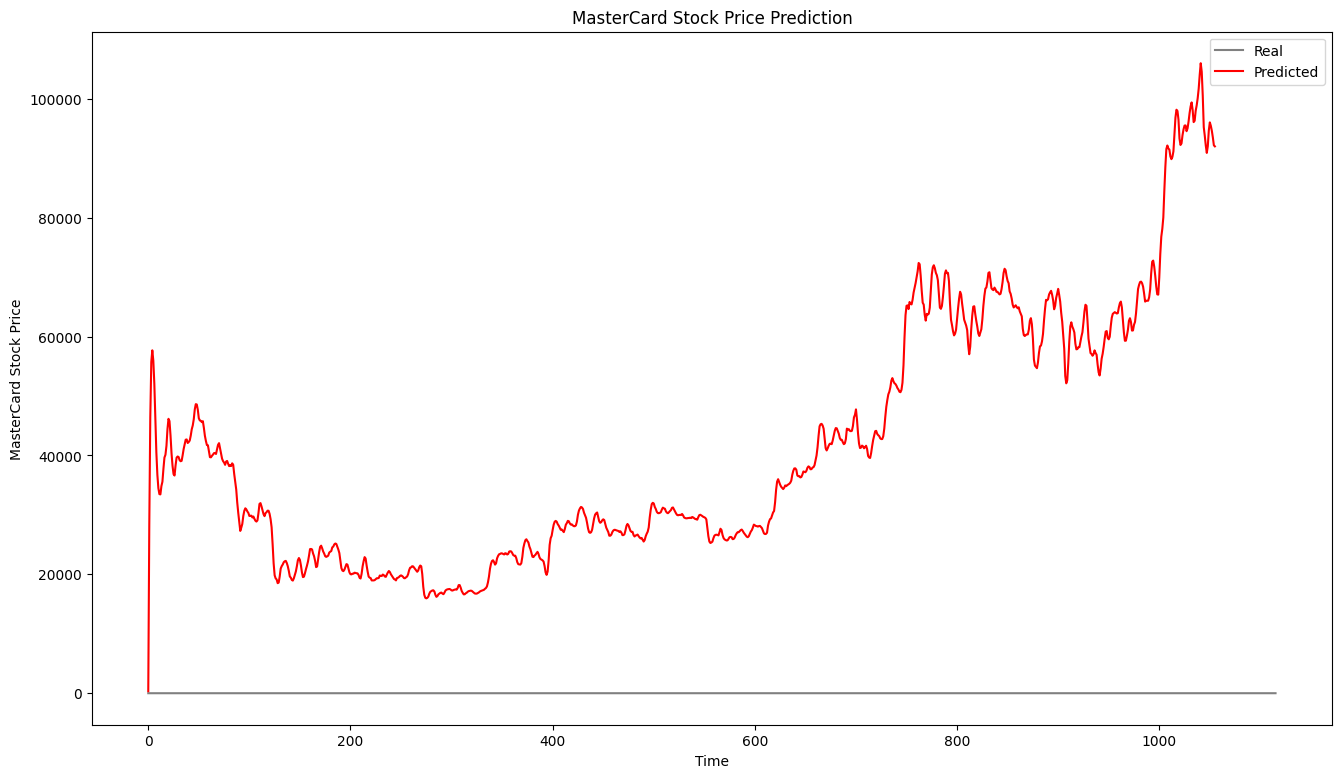

In [174]:
plot_predictions(inputs, predicted_stock_price)

In [175]:
return_rmse(test_data, predicted_stock_price)

The root mean squared error is 46023.34.
